# Atividade 01: Classificador *k-Nearest Neighbor* (kNN)

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

O classificador Knn consiste de duas etapas:

- Durante o treinamento, o classificador simplesmente armazena os dados de treinamento
- Durante o teste, o classificador calcula a distância entre cada objeto de teste e todos os dados de treinamento, utilizando os rótulos dos k mais similares (ou próximos) para determinar o rótulo dos objetos de teste
- O valor de k pode ser determinado via validação cruzada

Neste exercício, você irá implementar esses passos e entender as etapas básicas (*pipeline*) da classificação de imagens e da validação cruzada; além de ganhar proficiência na escrita de código eficiente e paralelo/vetorizado.

In [1]:
# Executa algum código de inicialização desse notebook.

import random
import numpy as np
from dl.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from collections import Counter
import operator

from __future__ import print_function

# Um pouco de 'mágica': Isto permite que as figuras geradas pela biblioteca matplotlib apareçam dentro do notebook
# ao invés de aparecer em uma nova janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # fixa tamanho default para as plotagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Um pouco mais de 'mágica', assim o notebook irá recarregar módulos python externos;
# veja mais em http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload

print('Okay!')

Okay!


In [2]:
# Carrega os dados brutos da base CIFAR-10.
# Para tanto, você deve ter feito o download de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# e descompactado no diretório abaixo
cifar10_dir = 'dl\datasets\cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Apenas para verificação, vamos exibir o tamanho dos dados de treinamento e teste.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

print('Okay!')

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Okay!


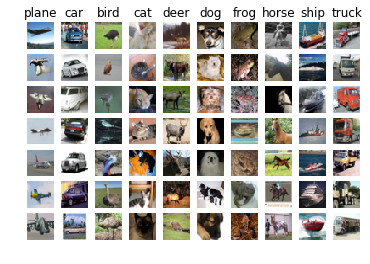

Okay!


In [3]:
# Visualizar alguns exemplos do dataset.
# São exibidos apenas 7 exemplos de imagens de treinamento de cada classe.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

print('Okay!')

In [4]:
# Realiza subamostragem dos dados para maior eficiência na execução do código desse exercício
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

print('Okay!')

Okay!


In [5]:
# Reformata os dados das imagens, assim as matrizes são transformadas em vetores
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

print('Okay!')

(5000, 3072) (500, 3072)
Okay!


In [6]:
from dl.classifiers import KNearestNeighbor

# Cria uma instância do classificador kNN. 
# Lembre-se que o treinamento de um classificador kNN é trivial: 
# o classificador simplemente armazena os dados sem nenhum processamento adicional 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

print('Okay!')

Okay!


Agora, você deve classificar os dados de teste com o classificador kNN. Lembre-se de que esse processo pode ser dividido em dois passos:

1. Primeiro, deve-se calcular as distâncias entre todas as amostras de teste e todos os dados de treinamento.
2. Dadas essas distâncias, para cada amostra de teste, deve-se encontrar os k exemplos mais próximos entre os dados de treinamento e utilizá-los para uma **votação**, de forma a determinar o rótulo da amostra teste.

Vamos iniciar calculando a matriz de distância entre todos os dados de treinamento e amostras de teste. Por exemplo, se existirem **Ntr** exemplos de treinamento e **Nte** amostras de teste, esta etapa resulta em uma matriz **Nte x Ntr**, em que cada elemento (*i*, *j*) representa a distância entre a *i*-ésima amostra de teste e o *j*-ésimo exemplos de treinamento. 

Primeiramente, abra o arquivo `dl/classifiers/k_nearest_neighbor.py` e implemente a função `compute_distances_two_loops` que utiliza dois laços (muito ineficiente) para iterar sobre todos os pares de exemplos (teste, treino) e calcular a matriz de distância (um elemento por vez).

In [7]:
# Abra o arquivo dl/classifiers/k_nearest_neighbor.py e implemente a função
# compute_distances_two_loops.

# Agora teste sua implementação:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

#DONE

print('Okay!')

(500, 5000)
Okay!


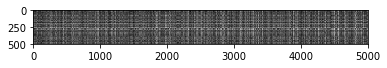

Okay!


In [8]:
# Pode-se visualizar a matriz de distância: cada linha está associada a uma única amostra de teste e
# e suas distâncias para os exemplos de treinamento
plt.imshow(dists, interpolation='none')
plt.show()

print('Okay!')

**Pregunta #1:** Observe os padrões que surgem na matriz de distância, em que algumas linhas e colunas são visivelmente mais claras (vale dizer que o esquema de cores padrão que foi utilizado, preto indica distâncias pequenas enquanto branco representa distâncias grandes).

- O que você pode dizer sobre os dados que explique as linhas mais claras?
- E, em relação as colunas mais claras?

**Sua Resposta**: .



Em seguida, pode-se realizar predições utilizando a matriz de distância calculada. Para tanto, você deve implementar a função `predict_labels` dentro no mesmo arquivo `dl/classifiers/k_nearest_neighbor.py`. Não esqueça de **salvar as alterações** no final (e antes de realizar o teste a seguir). 

In [9]:
# Agora, você pode testar a função predict_labels executando o código a seguir:
# Utilizou-se k = 1 (que representa o suo apenas do VIZINHO MAIS PRÓXIMO).

y_test_pred = classifier.predict_labels(dists, k=1)

# Calcula e exibe a fração de amostras corretamente preditas
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

print('Okay!')

Got 137 / 500 correct => accuracy: 0.274000
Okay!


Você deve esperar ver aproximadamente `27%` de acurácia. Agora, vamos experimentar com um valor maior de `k`, p.ex. `k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

print('Okay!')

Got 145 / 500 correct => accuracy: 0.290000
Okay!


Você deve esperar ver uma performance ligeiramente melhor que a obtida com `k = 1`.

**Paralelismo**: Agora, vamos tentar aumentar a velocidade de execução utilizando operações vetoriais!

In [12]:
# Primeiro, vamos acelerar o cálculo da matriz de distância por meio da paralelização 
# de um dos laços. Implemente a função compute_distances_one_loop e execute o código
# abaixo:
dists_one = classifier.compute_distances_one_loop(X_test)

# Para se garantir que sua implementação paralelizada está correta, deve-se verificar
# que seu resultado coincide com o da implementação ingênua (ou trivial).

# Existem várias de se decidir se duas matrizes são similares; uma das formas mais 
# simples é a norma de Frobenius. Caso você não a conheça, a norma de Frobenius de 
# duas matrizes é a raiz quadrada da soma dos quadrados das diferenças entre todos  
# os elementos correspondentes das duas matrizes. Em outras palavras, é como se 
# reformatássemos as matrizes como vetores e calculássemos a distância euclidiana
# entre eles.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')
    
print('Okay!')

Difference was: 0.000000
Good! The distance matrices are the same
Okay!


In [13]:
# Em seguida, implemente o cálculo da matriz de distância completamente vetorizado 
# dentro da função compute_distances_no_loops e teste com o código abaixo
dists_two = classifier.compute_distances_no_loops(X_test)

# Verifique se a matriz de distância obtida coincide com a calculada anteriormente:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')
    
print('Okay!')

Difference was: 0.000000
Good! The distance matrices are the same
Okay!


In [14]:
# Agora, pode-se comparar a velocidade de suas implementações
def time_function(f, *args):
    """
    Chama uma funcao f com args e retorna o tempo (em segundos) que ela levou para executar.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# OBS: você deve ver uma execução significativamente mais rápida com a implementação completamente vetorizada

print('Okay!')

Two loop version took 37.431799 seconds
One loop version took 82.545642 seconds
No loop version took 0.254319 seconds
Okay!


### Validação cruzada

Nesse ponto, você já implementou o classificador kNN, contudo o valor de k = 5 foi definido de forma arbitrária.

Pode-se agora procurar determinar o melhor valor para esse hiperparâmetro por meio de validação cruzada.

In [26]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Dividir os dados de treinamento em partições. Depois disso, X_train_folds    #
# e y_train_folds devem ser listas de tamanho num_folds, em que:               #
# y_train_folds[i] é o vetor de rótulos para os pontos em X_train_folds[i].    #
# DICA: Experimente usar a função array_split da biblioteca numpy.             #
################################################################################

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

################################################################################
#                              FIM DE SEU CÓDIGO                               #
################################################################################

# Declarou-se a seguir um dicionário para conter os valores de acurácia para 
# diferentes valores de k que forem encontrados durante a validação cruzada.
#
k_to_accuracies = {}
# Depois de executada a validação cruzada, espera-se que k_to_accuracies[k] 
# seja uma lista de tamanho igual a num_folds contendo os diferentes valores 
# de acurácia associados a esse valor de k que foram obtidos para cada um dos
# particionamentos

################################################################################
# TODO:                                                                        #
# Realizar a validação cruzada de k subconjuntos (folds) para encontrar o      #
# melhor valor de k. Para cada valor possível de k, executar o classificador   #
# kNN várias vezes (num_folds repetições), de forma que em cada execução       #
# todos com exceção de um dos subconjuntos (folds) são usados como dados de    #
# treinamento e o subconjunto deixado a parte é usado como conjunto de         #
# validação. Armazenar as acurácias obtidas para todos os subconjuntos e para  #
# todos os valores de k no dicionário denominado k_to_accuracies.              # 
################################################################################

for k in k_choices:
    k_to_accuracies[k] = []
    for fold in range(num_folds):
        train_X = np.append(X_train_folds[:fold], X_train_folds[fold+1:]).reshape((X_train.shape[0] - X_train.shape[0]//num_folds, -1))
        train_y = np.append(y_train_folds[:fold], y_train_folds[fold+1:]).reshape((y_train.shape[0] - y_train.shape[0]//num_folds, -1)).flatten()
        classifier.train(train_X, train_y)
        dists = classifier.compute_distances_no_loops(X_train_folds[fold])
        y_test_pred = classifier.predict_labels(dists, k)
        
        num_correct = np.sum(y_test_pred == y_train_folds[fold])
        accuracy = float(num_correct) / len(y_train_folds[fold])
        k_to_accuracies[k].append(accuracy)

################################################################################
#                              FIM DE SEU CÓDIGO                               #
################################################################################

# Exibe as acurácias calculadas
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))
        
print('Okay!')

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.273000
k = 3, accuracy = 0.282000
k = 3, accuracy = 0.270000
k = 5, accuracy = 0.265000
k = 5, accuracy = 0.275000
k = 5, accuracy = 0.295000
k = 5, accuracy = 0.298000
k = 5, accuracy = 0.284000
k = 8, accuracy = 0.272000
k = 8, accuracy = 0.295000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.298000
k = 8, accuracy = 0.290000
k = 10, accuracy = 0.272000
k = 10, accuracy = 0.303000
k = 10, accuracy = 0.289000
k = 10, accuracy = 0.292000
k = 10, accuracy = 0.285000
k = 12, accuracy = 0.271000
k = 12, accuracy = 0.305000
k = 12, accuracy = 0.285000
k = 12, accuracy = 0.289000
k = 12, accuracy = 0.281000
k = 15, accuracy = 0.260000
k = 15, accuracy = 0.302000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.285000
k = 20, accuracy = 0.268000
k = 20, accu

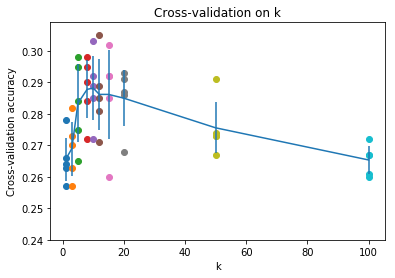

Okay!


In [27]:
# Plota as observações brutas
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# Plota linha de tendência com barras de erro que correspondem ao desvio padrão 
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

print('Okay!')

In [28]:
# Com base nos resultados da validação cruzada acima, escolha o melhor valor para k
# (e insira na linha abaixo como 'best_k'). Em seguida, treine novamente o classificador 
# e realize os testes.
# Você deve ser capaz de obter uma acurácia acima de 28% nos dados de teste.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Calcula e exibe a acurácia
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

print('Okay!')

Got 144 / 500 correct => accuracy: 0.288000
Okay!
